# GRU

# Preprocessing

In [55]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import numpy as np
import io
import re
import string
import tqdm

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [56]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [57]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./data/text_emotion.csv")

## Data Cleaning
1. Getting rid of the punctuations marks from dataset
2. converting all content to lowercase
3. converting unicode characters to ascii

In [58]:
cleaned_df = df.copy()

# lowercasing 'content' column
cleaned_df['content'] = cleaned_df['content'].str.lower()

# removing all words with #hastag and @name and urls
cleaned_df['content'].apply(lambda sentence: re.sub('@[A-Za-z0-9_]+','',sentence))
cleaned_df['content'].apply(lambda sentence: re.sub('#[A-Za-z0-9_]+','',sentence))
cleaned_df['content'].apply(lambda sentence: re.sub(r'http\S+','',sentence))

# removing all punctuation marks
exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: regex.sub("",sentence))

# removing unicode characters
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: sentence.encode("ascii","ignore").decode())


1. Now we want to find the total number of unique words (vocab_size) to rationalise the size of a embedding vector
1. We also want to find the maximum number of words that are in a sentence to justify the size of the input layer of the GRU

In [59]:
max_sentence_len = cleaned_df['content'].apply(lambda s: len(s.split())).max()
no_of_words = cleaned_df['content'].apply(lambda content: len(content.split())).sum()


# count vocab size
cache=set()

#counting padding and [unkownd] token
vocab_size= 1
for key,sentence in cleaned_df['content'].items():
    words = sentence.split()
    for word in words:
        if(word not in cache):
            vocab_size+=1
            cache.add(word)
            
print("max sentence length of 'content' is {}".format(max_sentence_len))
print("total number of words of content is {}".format(no_of_words))
print("total number of unique words/vocab_size of content is {}".format(vocab_size))

max sentence length of 'content' is 33
total number of words of content is 522873
total number of unique words/vocab_size of content is 53611


Since our max sentence length is 33 we will make an embedding of shape (64,) and pad the difference of the sentence. <br>
Since it is computationally heavy to have a vector of 63612 in size. <br>
We will use a vector of only 64, meaning that in the skip_grams algorithm, the words will only take 64 other context words into account

# using word2Vec to get continous vectors to use as embeddings instead of one-hot vectors
> using continuous vectors instead of one-hot vectors is better as continuos vectors contain contextual meaning learned from the unsupervised learning performed in the word2vec training process

Getting embeddings using Word2Vec. Word2vec has 2 algorithms, 
1. Continuous Bag of words
    - word is predicted from context "__ my name is Kevin"
2. Skip Gram
    - context is predicted from target "Hi __ __ __ __"

Combine the steps to one function

In [60]:
def generate_training_data(sequences, window_size,num_ns,vocab_size,seed):
    
    # each training sentence is appended to these list
    targets,contexts,labels = [],[],[]
    
    # sampling table for vocab_size tokens
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # iterate over all sentences in dataset
    for sequence in tqdm.tqdm(sequences):
       

        # generating positive skip-gram pairs for a sequence
        positive_skip_grams,_ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size = vocab_size,
            sampling_table=sampling_table,
            window_size=window_size, # TODO: change window size
            negative_samples=0
        )
        
        # produce negative samples and create training samples (x_train,labels)
        for target_word, context_word in positive_skip_grams:
    
    
            # expand context word to frmo dim shape (1,0) to (1,1)
            context_class = tf.expand_dims(
                tf.constant([context_word],dtype='int64'),1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class, # to tell the which sample is positive
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size, #TODO: may need to change to just the negative samples of the sentence itself instead of the entire vocab
                seed=seed,
                name='negative_sampling')
    
    
            # building the context and label vectors for a target word
            context = tf.concat([tf.squeeze(context_class,1),negative_sampling_candidates],0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")
    
    
            # append each element from the training ex to global lists
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
    
    return targets, contexts, labels 
            
            

## Preparing training data for word2vec

In [61]:
# size of one sentence is 33 but we just use 64
sequence_length = 33

vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

## Tokenise the words in content according to their indices

### replace words with their respective tokens:

In [69]:
# creating a dataset of all sentences
text_ds = tf.data.Dataset.from_tensor_slices(cleaned_df['content'])
vectorize_layer.adapt(text_ds.batch(batch_size))

### build a inverse vocab which maps indexes -> words which can be handy

In [70]:
inverse_vocab = vectorize_layer.get_vocabulary()

In [71]:
# Vectorize the data in text_ds.
# prefetch does fetching of data and training at the same time using multiple thread
# improving performance
text_vector_ds = text_ds.batch(batch_size).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

As you can see we have successfully vectorised our sentences/sequences

In [72]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

40000


## Using unsupervised learning (word2Vec skip_gram) to predict context from targets. 
>While doing so, we are also training the weights on the embeddings. We can increase window size so that the embeddings learn more contextutal knowledge with respect to the words around them

In [73]:
# to determine window size, we see the median length of a sentence

print(cleaned_df['content'].apply(lambda s: len(s.split())).median())
print(cleaned_df['content'].apply(lambda s: len(s.split())).mean())

12.0
13.071825


We go with window size of 7 since that the median length of a sentence is 12. we want to offer 5 slotssome space for negative sampling

In [75]:
# note higher window size is more computationally expensive
# from documentation, it is said that for small datasets, negative samples of range 5to 20 yields the best results

WINDOW_SIZE = 7
num_ns = 5

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=WINDOW_SIZE,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [02:20<00:00, 285.29it/s]




targets.shape: (1089369,)
contexts.shape: (1089369, 6)
labels.shape: (1089369, 6)


## Configuring training sets for Word2Vec model

In [94]:
# batching the dataset
BATCH_SIZE = 256
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(256,), dtype=tf.int64, name=None), TensorSpec(shape=(256, 6), dtype=tf.int64, name=None)), TensorSpec(shape=(256, 6), dtype=tf.int64, name=None))>


In [95]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(256,), dtype=tf.int64, name=None), TensorSpec(shape=(256, 6), dtype=tf.int64, name=None)), TensorSpec(shape=(256, 6), dtype=tf.int64, name=None))>


In [96]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
              embedding_dim,
              input_length=1,
              name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
               embedding_dim,
               input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [97]:
# embedding size for word2vec is chosen to be of shape (32,)
# the idea is that since there are a maximum of 33 words in a sentece
# the vector that a word takes will be in 32 dimension 
# vocab size +1 because of padding
embedding_dim = 50

word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
# call back to log training stats for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [99]:
history = word2vec.fit(dataset, epochs=15, callbacks=[tensorboard_callback])

Epoch 1/15
4255/4255 [==============================] - 158s 37ms/step - loss: 1.6636 - accuracy: 0.2817
Epoch 2/15
4255/4255 [==============================] - 157s 37ms/step - loss: 1.5417 - accuracy: 0.3807
Epoch 3/15
4255/4255 [==============================] - 161s 38ms/step - loss: 1.3712 - accuracy: 0.4876
Epoch 4/15
4255/4255 [==============================] - 162s 38ms/step - loss: 1.1944 - accuracy: 0.5696
Epoch 5/15
4255/4255 [==============================] - 158s 37ms/step - loss: 1.0417 - accuracy: 0.6315
Epoch 6/15
4255/4255 [==============================] - 159s 37ms/step - loss: 0.9181 - accuracy: 0.6777
Epoch 7/15
4255/4255 [==============================] - 157s 37ms/step - loss: 0.8207 - accuracy: 0.7124
Epoch 8/15
4255/4255 [==============================] - 157s 37ms/step - loss: 0.7446 - accuracy: 0.7391
Epoch 9/15
4255/4255 [==============================] - 157s 37ms/step - loss: 0.6849 - accuracy: 0.7594
Epoch 10/15
4255/4255 [==============================] 

Text(0, 0.5, 'loss')

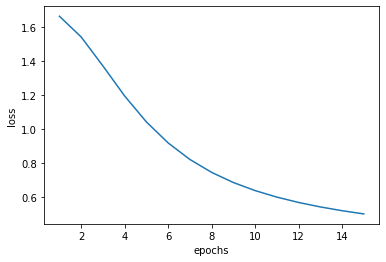

In [108]:
import matplotlib.pyplot as plt
y = history.history['loss']
x = [i+1 for i in range(0,len(y))]
plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')

## Writing vectors to file

In [109]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [110]:
out_v = io.open('./data/vectors1.tsv', 'w')
out_m = io.open('./data/metadata1.tsv', 'w')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# GRU model

In [111]:
def read_tsv(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
        result.append([float(value) for value in line.split()])
        
    file.close()
    return result

In [112]:
vectors = read_tsv('./data/vectors1.tsv')

2022-11-03 21:17:13.539047: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-03 21:17:13.542948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-03 21:17:13.553089: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

In [113]:
def read_meta(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
            
        result.append(line.strip())
    file.close()
    return result

In [114]:
classes = read_meta('./data/metadata1.tsv')

In [115]:
len(classes)

53610

## Preprocessing for GRU: one hot encoding the labels

In [116]:
print('Unique labels:')
for i, label in enumerate(cleaned_df['sentiment'].unique()):
    print('{}) {}'.format(i,label)) 

Unique labels:
0) empty
1) sadness
2) enthusiasm
3) neutral
4) worry
5) surprise
6) love
7) fun
8) hate
9) happiness
10) boredom
11) relief
12) anger


In [117]:
cleaned_df['sentiment'].nunique()

13

# Build a one hot vector each of size 13 for sentiments as labels

### build a map for the labels to the indices

In [118]:
# map labels -> indices
sentiment_labels = cleaned_df['sentiment'].unique().copy()

# index key -> class
label_map = {}

#class -> index key
inverse_label_map = {}
for i, label in enumerate(sentiment_labels):
    label_map[i] = label 
    inverse_label_map[label] = i

In [119]:
# get all keys
indices = []
for key,value in label_map.items():
    indices.append(key)

### Generates one-hot vector for labels

In [120]:
# maps the word to the one hot vector
depth = len(indices)
one_hot_encoding = tf.one_hot(indices,depth)

In [121]:
one_hot_encoding

<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)>

In [122]:
one_hot_encoding.shape

TensorShape([13, 13])

Map the one hot encodings to the labels in the dataframe

In [123]:
cleaned_df['sentiment'].values

array(['empty', 'sadness', 'sadness', ..., 'love', 'happiness', 'love'],
      dtype=object)

In [124]:
labels=[]
for sentiment in tqdm.tqdm(cleaned_df['sentiment'].values):
    o_h = one_hot_encoding[inverse_label_map[sentiment]]
    labels.append(o_h)

labels = np.asarray(labels)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:04<00:00, 8911.85it/s]


In [125]:
labels.shape

(40000, 13)

Getting embeddings using Word2Vec. Word2vec has 2 algorithms, 
1. Continuous Bag of words
    - word is predicted from context "__ my name is Kevin"
2. Skip Gram
    - context is predicted from target "Hi __ __ __ __"

## Convert Content to tokenized vectors

In [126]:
content_lines = list(cleaned_df['content'])
tokeniser_obj = Tokenizer()
tokeniser_obj.fit_on_texts(content_lines)
sequences = tokeniser_obj.texts_to_sequences(content_lines)

# pad sequences
word_index = tokeniser_obj.word_index
print('Found {} unique tokens'.format(len(word_index)))

max_length = max_sentence_len
content_pad = pad_sequences(sequences,maxlen=max_length)
print("labels: {}".format(labels))

Found 53610 unique tokens
labels: [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [127]:
print("shape of content tensor: {}".format(content_pad.shape))
print("shape of sentiment tensor: {}".format(labels.shape))

shape of content tensor: (40000, 33)
shape of sentiment tensor: (40000, 13)


## Map embeddings from word2vec model for each word to the sequences (sentences) by creating a matrix

Map the embeddings to each word of the sentence

In [129]:
# make an inverse index of the classes name -> index
word_vector_map = {}
for index,word in enumerate(classes):
    word_vector_map[word] = vectors[index]

In [130]:
EMBEDDING_DIM=50
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))

In [131]:
embedding_matrix.shape

(53611, 50)

In [135]:
count = 0
for word,i in word_index.items():
    if i> num_words:
        continue
    embedding_vector = word_vector_map.get(word)
    if(embedding_vector is not None):
        # if embedding vector is not found, 
        embedding_matrix[i] = embedding_vector
        count+=1
    else:
        print(word)
print("number of words successfully mapped to vectors: {}/{}".format(count,vocab_size))

00
number of words successfully mapped to vectors: 53609/53611


# Model of GRU

x (no_sequences,embeddings in a sequence=32,)

In [136]:
# callback to save the best weights for the model
def saveWeightsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
        mode = mode,
        save_freq=save_freq,
)

In [137]:
from keras.initializers import Constant

def build_model(vocab_size,embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_words,
                               EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length = max_length,
                              trainable=False))
    model.add(layers.GRU(128,return_sequences=True))
    model.add(layers.GRU(128,return_sequences=True))
    model.add(layers.GRU(128)) 
    model.add(layers.Dense(13,activation='softmax'))
    model.summary()
    return model

In [138]:
GRU_model = build_model(vocab_size,EMBEDDING_DIM,max_length)

GRU_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 33, 50)            2680550   
                                                                 
 gru_3 (GRU)                 (None, 33, 128)           69120     
                                                                 
 gru_4 (GRU)                 (None, 33, 128)           99072     
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 13)                1677      
                                                                 
Total params: 2,949,491
Trainable params: 268,941
Non-trainable params: 2,680,550
_________________________________________________________________
Model: "sequential_1"
________________

In [139]:
VALIDATION_SPLIT = 0.3

indices = np.arange(content_pad.shape[0])
np.random.shuffle(indices)

content_pad = content_pad[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * content_pad.shape[0])

X_train_pad = content_pad[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_test_pad = content_pad[-num_validation_samples:]
y_test = labels[-num_validation_samples:]

In [141]:
history = GRU_model.fit(X_train_pad,
                        y_train,
                        batch_size=32,
                        epochs = 20,
                        verbose=2,
                        validation_data = (X_test_pad,y_test))

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
                     saveWeightsCallback(
                         path='./weights/GRU_word2vec',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],
         

Epoch 1/20
875/875 - 58s - loss: 2.0097 - accuracy: 0.3022 - val_loss: 2.0361 - val_accuracy: 0.3013 - 58s/epoch - 66ms/step
Epoch 2/20
875/875 - 62s - loss: 1.9980 - accuracy: 0.3060 - val_loss: 2.0223 - val_accuracy: 0.3061 - 62s/epoch - 70ms/step
Epoch 3/20
875/875 - 67s - loss: 1.9911 - accuracy: 0.3101 - val_loss: 2.0178 - val_accuracy: 0.3073 - 67s/epoch - 76ms/step
Epoch 4/20
875/875 - 59s - loss: 1.9858 - accuracy: 0.3125 - val_loss: 2.0158 - val_accuracy: 0.3087 - 59s/epoch - 67ms/step
Epoch 5/20
875/875 - 59s - loss: 1.9791 - accuracy: 0.3118 - val_loss: 2.0161 - val_accuracy: 0.3085 - 59s/epoch - 67ms/step
Epoch 6/20
875/875 - 59s - loss: 1.9746 - accuracy: 0.3171 - val_loss: 2.0098 - val_accuracy: 0.3085 - 59s/epoch - 67ms/step
Epoch 7/20
875/875 - 59s - loss: 1.9691 - accuracy: 0.3189 - val_loss: 2.0108 - val_accuracy: 0.3090 - 59s/epoch - 67ms/step
Epoch 8/20
875/875 - 59s - loss: 1.9639 - accuracy: 0.3195 - val_loss: 2.0085 - val_accuracy: 0.3056 - 59s/epoch - 67ms/step


# Plot loss and accuracy of GRU Model 

Text(0, 0.5, 'loss')

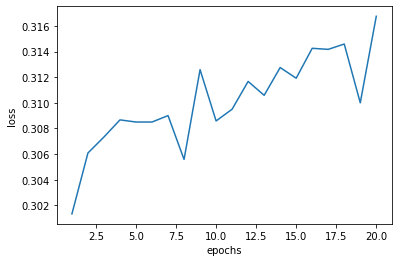

In [143]:
y = history.history['val_accuracy']
x = [i+1 for i in range(0,len(y))]
plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')

# implementing GRU without word2vec

In [ ]:
depth = len(indices)
one_hot_encoding = tf.one_hot(indices,depth)

2022-11-03 06:10:33.270883: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400000000 exceeds 10% of free system memory.


In [ ]:
labels=[]
for sentiment in tqdm.tqdm(cleaned_df['sentiment'].values):
    o_h = one_hot_encoding[inverse_label_map[sentiment]]
    labels.append(o_h)

labels = np.asarray(labels)

In [ ]:
train_split = int(0.7*len(cleaned_df['content']))
X_train = cleaned_df.loc[:train_split-1,'content']
y_train = labels[:train_split]

X_test = cleaned_df.loc[train_split:,'content']
y_test = labels[train_split:]

In [ ]:
tokeniser_obj = Tokenizer()
total_contents = cleaned_df['content']
tokeniser_obj.fit_on_texts(total_contents)

#pad sequences
max_length = max([len(s.split()) for s in total_contents])

# define vocan size 
vocab_size = len(tokeniser_obj.word_index)+1

X_train_tokens =  tokeniser_obj.texts_to_sequences(X_train)
X_test_tokens =tokeniser_obj.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens,maxlen=max_length,padding='post')
X_test_pad = pad_sequences(X_test_tokens,maxlen=max_length,padding='post')

In [ ]:
model = keras.models.Sequential()

EMBEDDING_DIM = 100

model.add(layers.Embedding(vocab_size,EMBEDDING_DIM,input_length=max_length))
model.add(layers.GRU(units=32,dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(13,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train_pad,y_train,batch_size=128,epochs=28,validation_data=(X_test_pad,y_test),verbose=2)